# This notebook contains the Stacks parameter tests, final parameters used and analyses to identify sex linked markers for the RADseq dataset of <i> Lithobates montezumae </i> 
## Sample set:

A clucth of tadpoles without the father or mother or sex. Should be a challenge!


Contents:

1. Ustacks parameter tests & final parameters used
2. Cstacks parameter tests & final parameters used
3. Populations parameter tests & final parameters used
4. Identification of sex-linked markers

    
**Scripts for Incremental can be found in the Incremental module, 

**custom scripts for analyses of sex-linked markers can be found in the package "some_sexy_tools".

In [1]:
%matplotlib inline
import os
import wget ## used "sudo pip install wget" in command line to get package.
import Incremental_U as IncU ## Get this sorted
import Incremental_C as IncC
import Incremental_Pop_mod as IncPop
import MISC_RAD_tools as MISC
import pprint
import subprocess

In [2]:
%load_ext rpy2.ipython

In [5]:
working_directory = "/home/djeffrie/Data/RADseq/Lmontezumae_2/" ## Wherever you like

In [6]:
final_vcf = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all/batch_1.vcf"


Number of tags =  30156
Average tag coverage 17.2704553966 (+- 8.88113872405 )


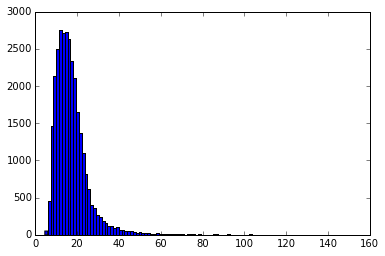

Mean sample coverage = 17.27 (+/3.38) 


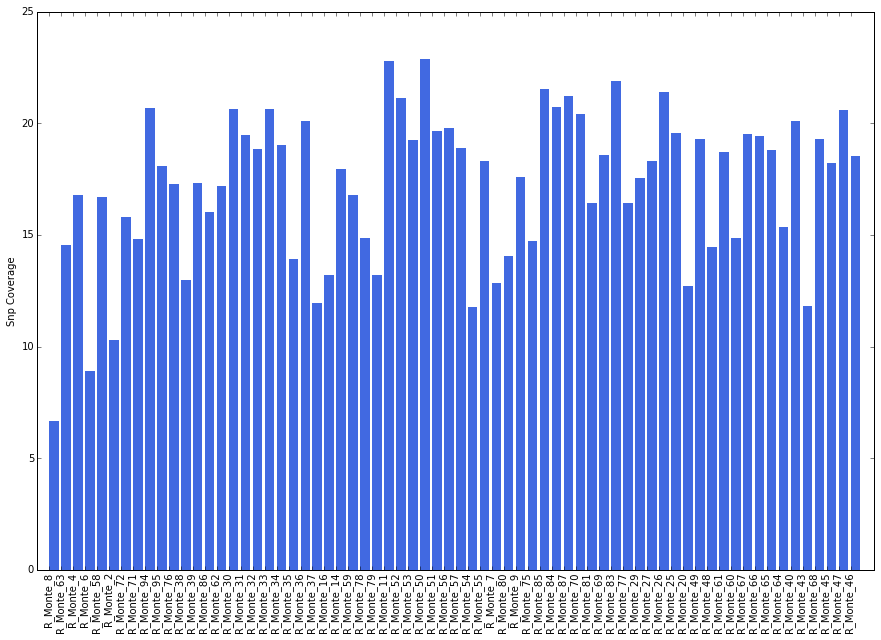

In [8]:
MISC.av_tag_cov(final_vcf, "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all/Av_tag_cov.out")
MISC.sample_Avcov_from_vcf(final_vcf)


### Now PCA to see whats what. . . 

In [10]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all/batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all/batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all/batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all/batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all/batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all/batch_1_altered_adegenet_plink-temporary.fam
written.
30156 variants loaded from .bim file.
68 people (0 males, 0 females, 68 ambiguous) loaded from .fam.
Ambigu

In [12]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Saving 19.7 x 19.7 in image

  warnings.warn(x, RRuntimeWarning)


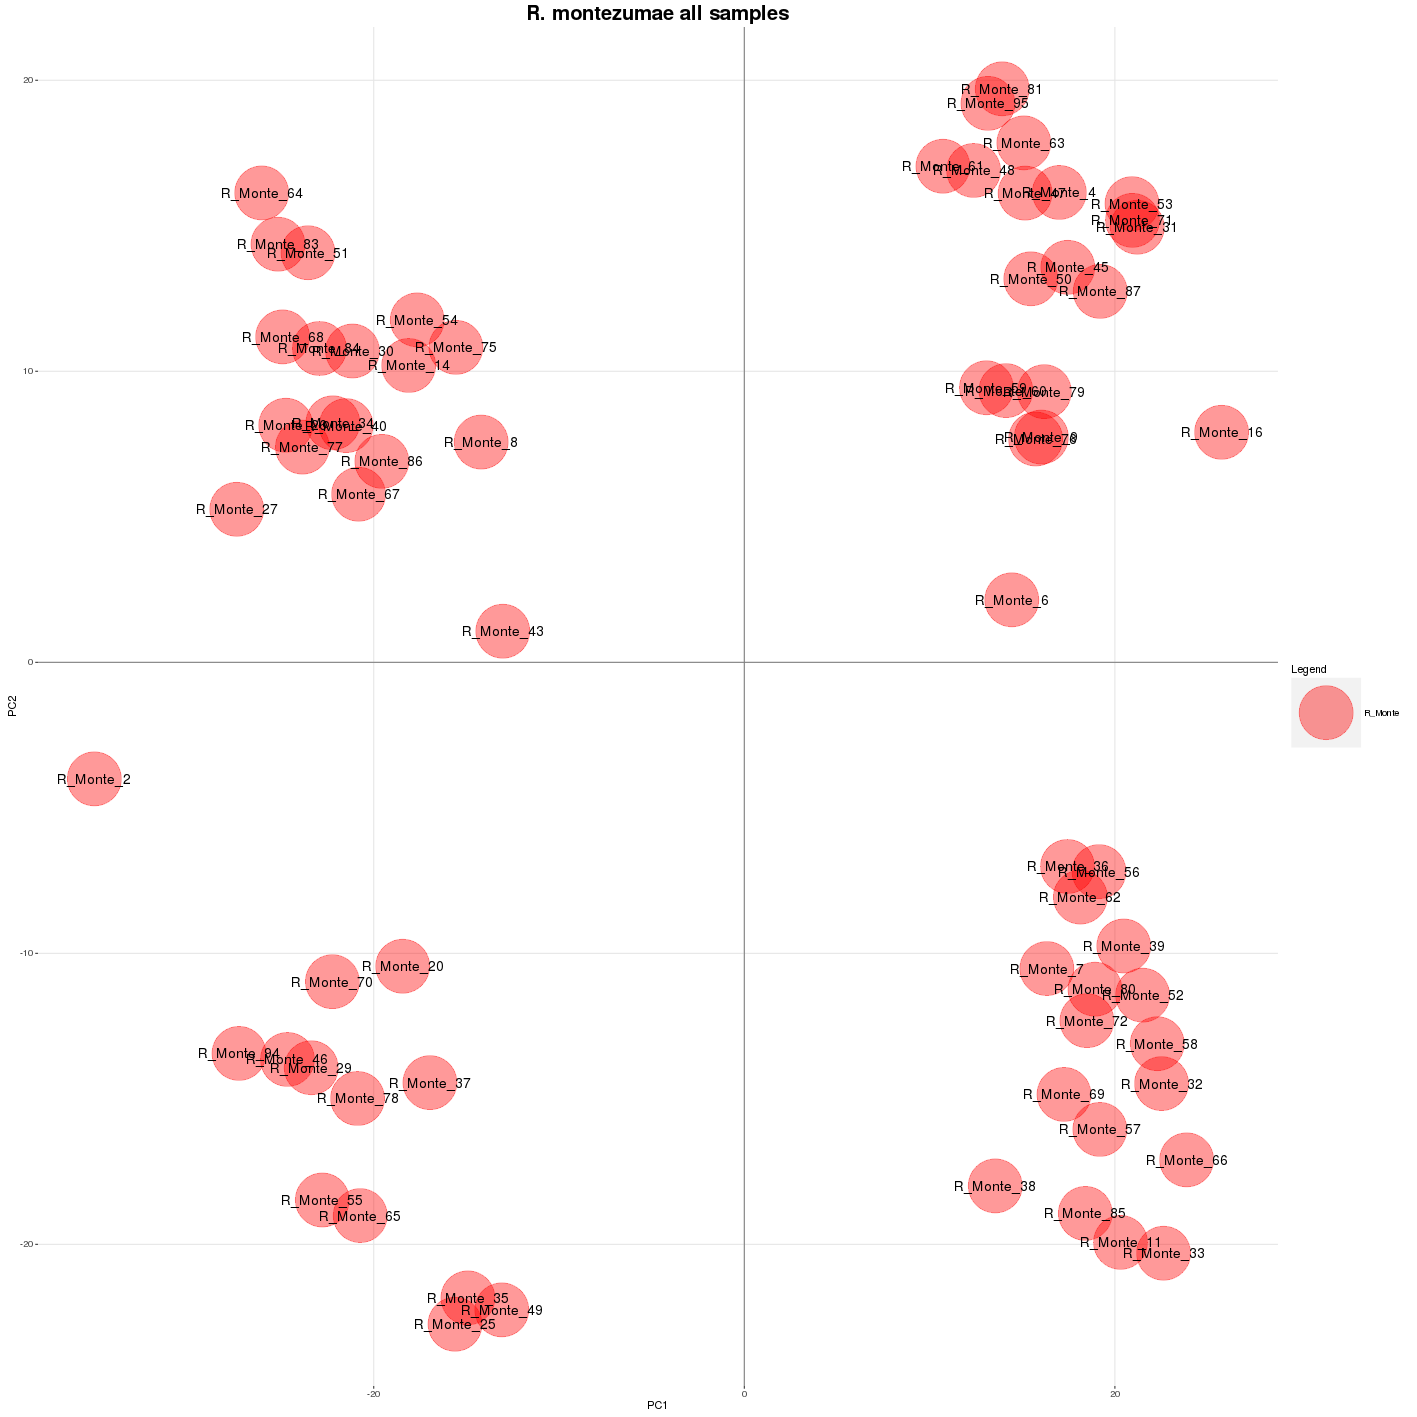

In [15]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("../popmap.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R. montezumae all samples", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

So there are clearly two families here, I think the family axes is PC2, so I will split the samples by this axis, and make the heatmap again. . . see what everything looks like 

In [16]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet_plink.raw  $wd/batch_1_heatmap_input


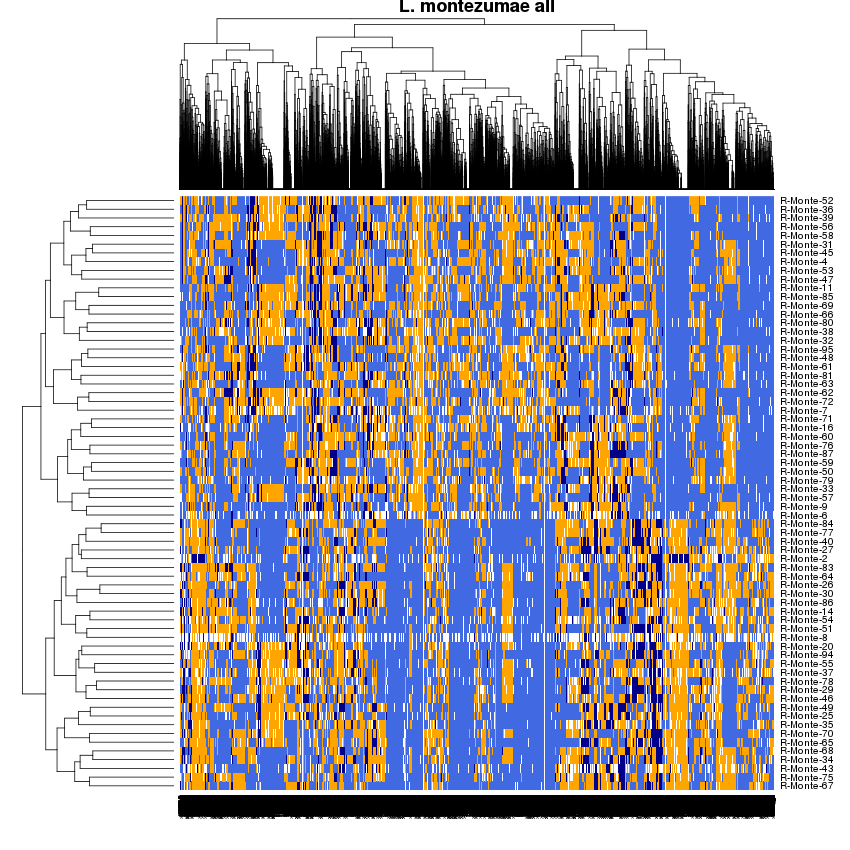

In [18]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_all/batch_1_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "L. montezumae all")

### Family 1 (top of PCA)

In [19]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1_altered_adegenet_plink-temporary.fam
written.
26819 variants loaded from .bim file.
39 people (0 males, 0 females, 39 ambiguous) loaded from .fam.


In [20]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



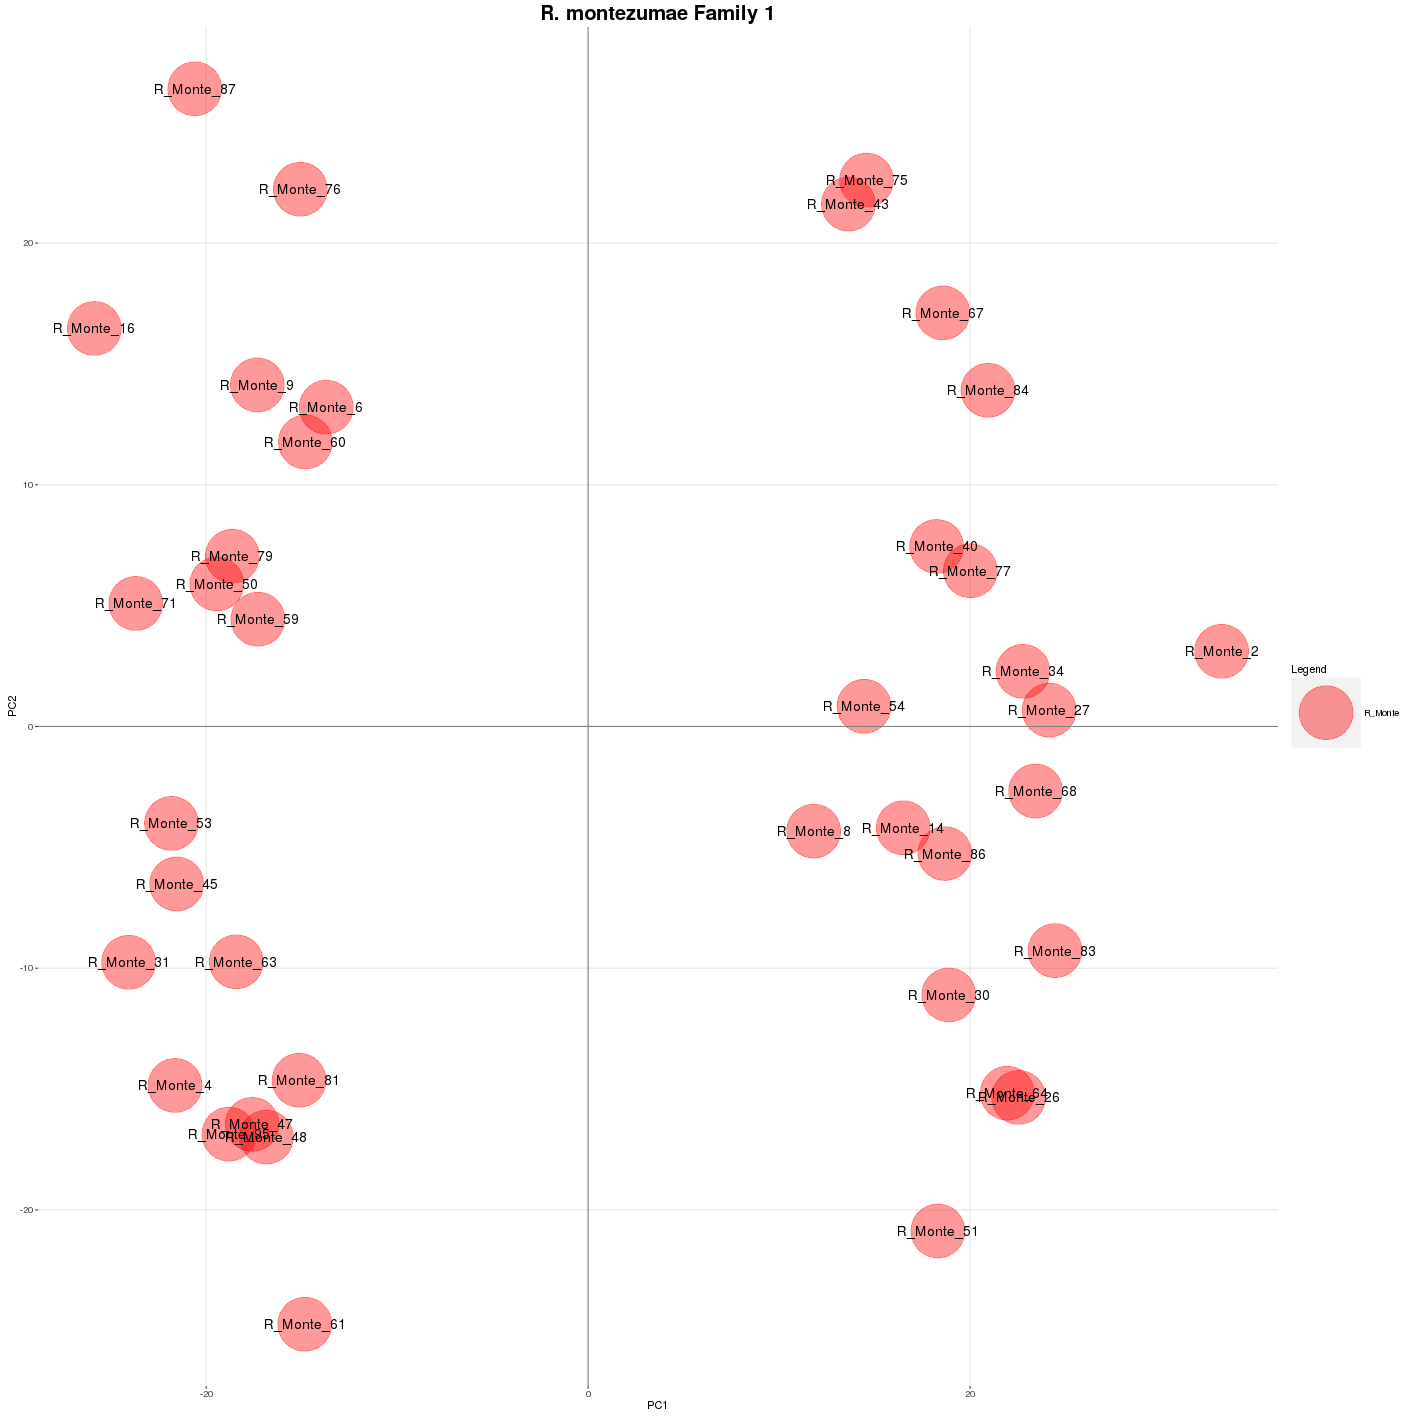

In [22]:
%%R -w 50 -h 50 -u cm

## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap_fam1.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R. montezumae Family 1", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [23]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet_plink.raw  $wd/batch_1_heatmap_input


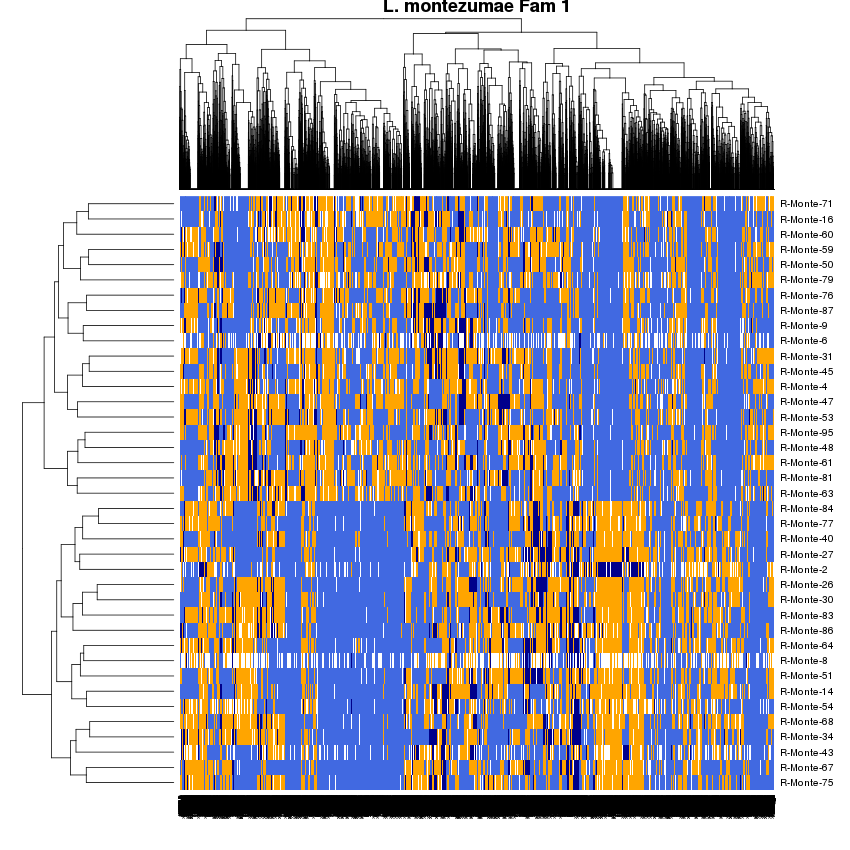

In [4]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "L. montezumae Fam 1")

## Family 2

In [46]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2  ## just change this line

## All data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

/home/djeffrie/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_altered_adegenet_plink


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/batch_1_altered_adegenet_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/batch_1_altered_adegenet_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/batch_1_altered_adegenet_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/batch_1_altered_adegenet_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/batch_1_altered_adegenet_plink-temporary.fam
written.
28600 variants loaded from .bim file.
29 people (0 males, 0 females, 29 ambiguous) loaded from .fam.


In [47]:
%%R

## Load packages and functions needed

library(adegenet)
library(ggplot2)
source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")

## Reading in the data -------------------------------------------------------------------------------

setwd("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/") 

## All SNPs (about 80,000)
alldata <- read.PLINK('batch_1_altered_adegenet_plink.raw', chunkSize=1000, parallel = TRUE, n.cores=1, saveNbAlleles=T) 



## Running PCA ---------------------------------------------------------------------------------------

pca1 <- glPca(alldata, parallel = TRUE, n.cores = 6, nf = 5) 


/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: ade4

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
   /// adegenet 2.0.1 is loaded ////////////

   > overview: '?adegenet'
   > tutorials/doc/questions: 'adegenetWeb()' 
   > bug reports/feature requests: adegenetIssues()



  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)



 Reading PLINK raw format into a genlight object... 


 Reading loci information... 

 Reading and converting genotypes... 
.
 Building final object... 

...done.



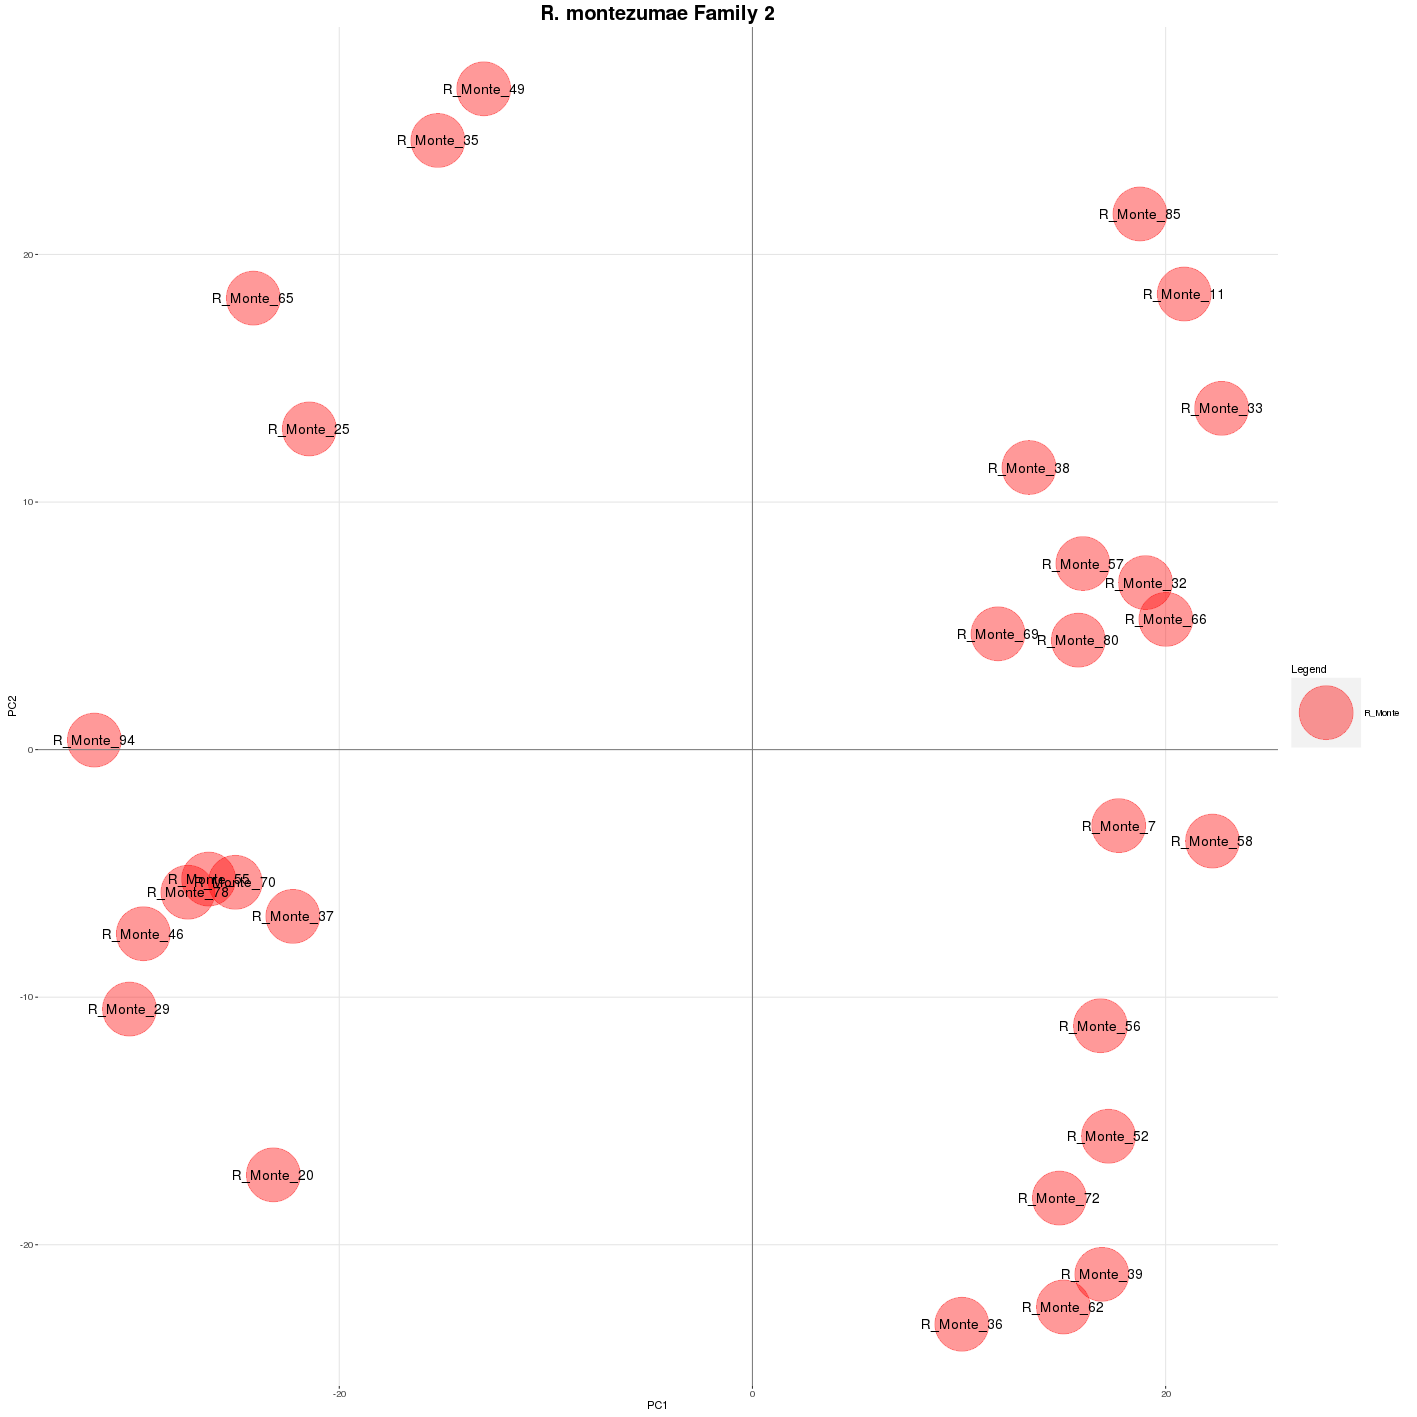

In [61]:
%%R -w 50 -h 50 -u cm

source("~/Dropbox/My_Dropbox_Scripts/R/My_functions/Sex_sorter_PCA_plotting_function.R")
## Plotting the PCAs using the Sex_sorter function.
sexes <- read.delim("popmap_fam2.txt", header = F)

Sex_sorter(pca1,   ## PCA object
           sexes,  ## sex_info file
           c(1,2), ## which components to plot
           Title = "R. montezumae Family 2", ## plot title
           xtitle = "PC1", ## X axis title
           ytitle = "PC2", ## Y axis title 
           Palette = rainbow(12), ## Colours to use
           func_cex = 5) ## Size of points and text in plots) 

In [62]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2

sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_altered_adegenet_plink.raw  $wd/batch_1_heatmap_input


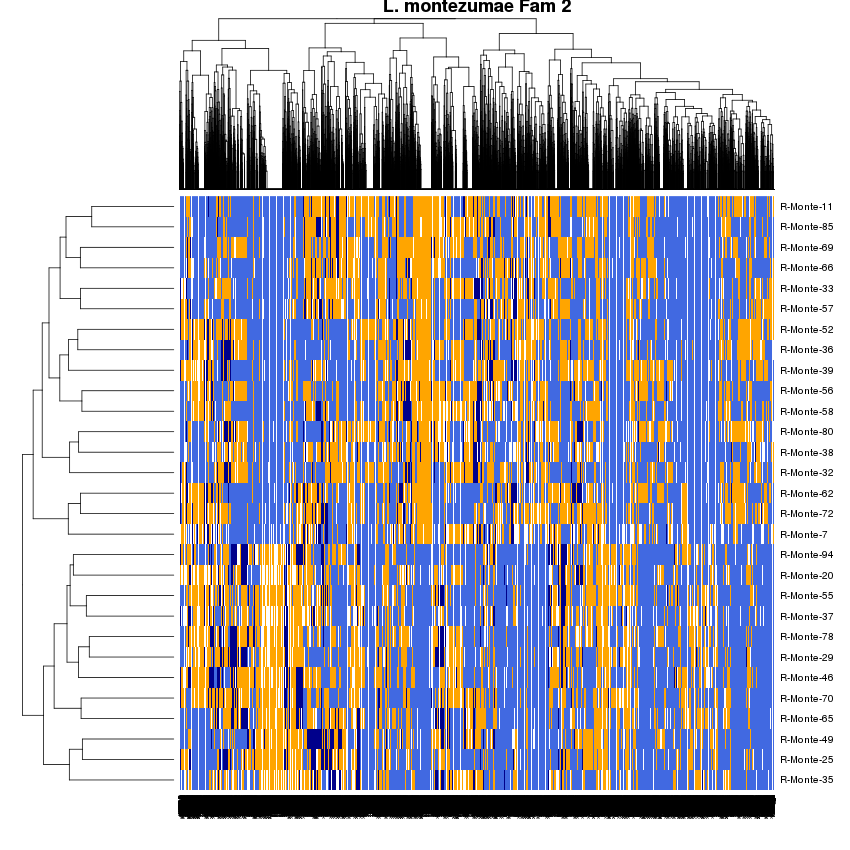

In [63]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/batch_1_heatmap_input.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "L. montezumae Fam 2")

## So . . . 

It is difficult to know which way round the sexes are, but there is a clear divide in the samples. I expect that I will get lots of both XY and ZW loci, but whichever way round it is, they should all fall on the same chromosome, as one set should represent Y specific SNPs and the other should represent X specific SNPs. 

So I will assign male and females and map all XY and ZW markers.

# Family 1

In [3]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Lmontezumae_2/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/Sex_ID_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 0.9 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 10 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [4]:
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 26819
Number of samples = 39
Number of loci with too few samples = 10834
Number of loci with low MAF = 0
Number of loci with enough data = 15962
Number of putative X linked snps = 615
Number of putative X linked tags = 615
Number of putative Z linked markers = 332
Number of putative Z linked tags = 332

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Lmontezumae_2

 ## After merging tags accross methods ## 

Final number of XY tags = 615
Final number of ZW tags = 332


In [5]:
vcf_path = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1.vcf"

MISC.filter_vcf(vcf_path, XYset , "Fam_1_XYs_linked_snps_het_only.vcf")

In [6]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/Fam_1_XYs_linked_snps_het_only.vcf > $wd/Fam_1_XY_linked_snps_het_only_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/Fam_1_XY_linked_snps_het_only_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/Fam_1_XY_linked_snps_het_only_altered_adegenet 

PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_XY_linked_snps_het_only_altered_adegenet.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_XY_linked_snps_het_only_altered_adegenet
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_XY_linked_snps_het_only_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_XY_linked_snps_het_only_altered_adegenet-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_XY_linked_snps_het_only_altered_adegenet-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_XY_linked_snps_het_only_altered_adegenet-temporary.fam
wr

In [7]:
%%bash
wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/
sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/Fam_1_XY_linked_snps_het_only_altered_adegenet.raw  $wd/Fam_1_XY_linked_snps_het_only_heatmap


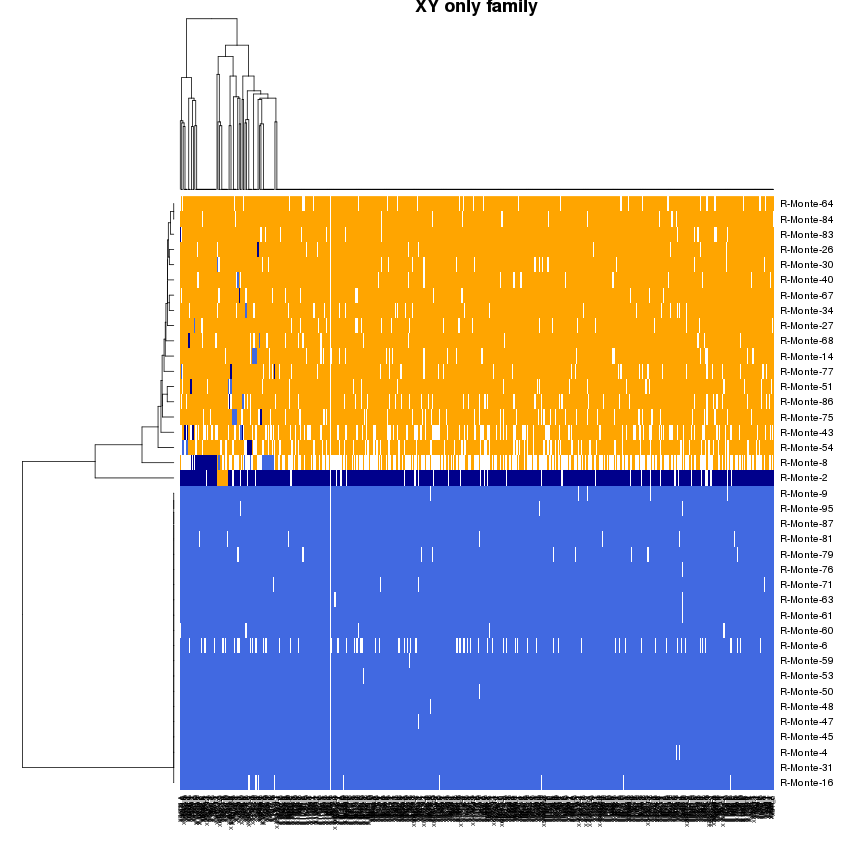

In [11]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/Fam_1_XY_linked_snps_het_only_heatmap.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "XY only family")



## Now lets map these to the genomes

In [37]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/"
prefix = "Lmont_fam1"

### Tags to Pless

print "\n##  Mapping tags to P. lessonae  ##\n"

tags ="%s/%s" % (wd, "Putative_XYlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to P. lessonae  ##

Number of multi-alingments kept: 29
Number of unique alingments kept: 43
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
72 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//blast_8000_chunks.fa

##  Mapping Rtemp chunks Nanorana  ##

Number of multi-alingments kept: 35
Number of unique alingments kept: 0
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
30 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//blast_8000_chunks.fa

##  Mapping Nanorana chunks Xenopus  ##

Number of multi-alingments kept: 5
Number of unique alingments kept: 3
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 
7 sequence

In [36]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Pless_fasta = "/home/djeffrie/Data/Genomes/Pless/PlesK49fill.fa"
Pless_db = "/home/djeffrie/Data/Genomes/Pless/Ples_blastn_db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/"
prefix = "Lmont_fam1"

### Tags to Pless

print "\n##  Mapping tags to P. lessonae  ##\n"

tags ="%s/%s" % (wd, "Putative_XYlinked_makers.fa")
tags_to_Pless_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Pless_db, outfmt=5, out=tags_to_Pless_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Pless_blastnouts, Pless_fasta , best_hit_crit, Eval_threshold,Window)

Pless_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Pless_blast_chunks)


### Pless chunks to Nanorana

print "\n##  Mapping Pless chunks Nanorana  ##\n"

tags_Pless_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Pless_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Pless_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Pless_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Pless_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Pless_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Pless_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Pless_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Pless_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Pless_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Pless_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Pless_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Pless_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Pless_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to P. lessonae  ##

Number of multi-alingments kept: 13
Number of unique alingments kept: 36
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Pless/PlesK49fill.fa . . . 
49 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//blast_8000_chunks.fa

##  Mapping Pless chunks Nanorana  ##

Number of multi-alingments kept: 22
Number of unique alingments kept: 1
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
21 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//blast_8000_chunks.fa

##  Mapping Nanorana chunks Xenopus  ##

Number of multi-alingments kept: 6
Number of unique alingments kept: 2
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 
8 sequence scaffold segments a

Chromsome 1 is the most likely candidate from this. 

## Now try the "ZW" tags

In [12]:
vcf_path = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/batch_1.vcf"

MISC.filter_vcf(vcf_path, ZWset , "Fam_1_ZWss_linked_snps_het_only.vcf")

In [13]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/Fam_1_ZWss_linked_snps_het_only.vcf > $wd/Fam_1_ZW_linked_snps_het_only_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/Fam_1_ZW_linked_snps_het_only_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/Fam_1_ZW_linked_snps_het_only_altered_adegenet 

PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_ZW_linked_snps_het_only_altered_adegenet.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_ZW_linked_snps_het_only_altered_adegenet
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_ZW_linked_snps_het_only_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_ZW_linked_snps_het_only_altered_adegenet-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_ZW_linked_snps_het_only_altered_adegenet-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//Fam_1_ZW_linked_snps_het_only_altered_adegenet-temporary.fam
wr

In [14]:
%%bash
wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/
sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/Fam_1_ZW_linked_snps_het_only_altered_adegenet.raw  $wd/Fam_1_ZW_linked_snps_het_only_heatmap


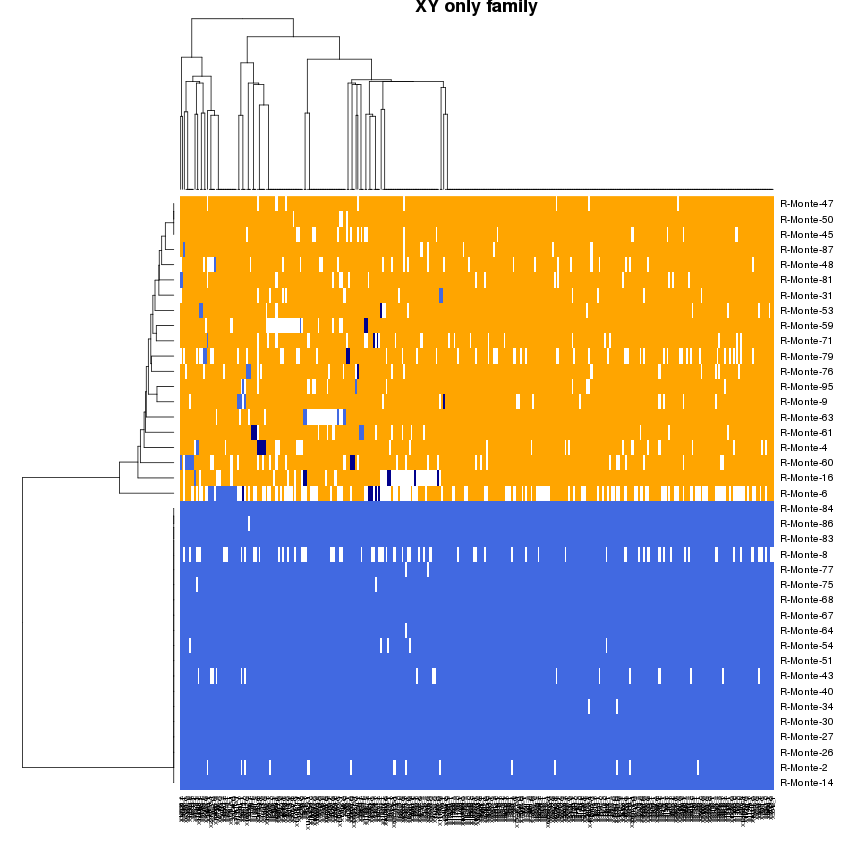

In [15]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/Fam_1_ZW_linked_snps_het_only_heatmap.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "XY only family")



In [42]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1/"
prefix = "Lmont_fam1"

### Tags to Pless

print "\n##  Mapping tags to P. lessonae  ##\n"

tags ="%s/%s" % (wd, "Putative_ZWlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to P. lessonae  ##

Number of multi-alingments kept: 2
Number of unique alingments kept: 20
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
22 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//blast_8000_chunks.fa

##  Mapping Rtemp chunks Nanorana  ##

Number of multi-alingments kept: 13
Number of unique alingments kept: 2
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
13 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1//blast_8000_chunks.fa

##  Mapping Nanorana chunks Xenopus  ##

Number of multi-alingments kept: 2
Number of unique alingments kept: 2
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 
4 sequence 

OK, So the results are:
    
    
    Chr01 - 6
    Chr09 - 5
    Chr05 - 3
    Chr06 - 3
    Chr02 - 1

Not conclusive - what about the second family.



## Now Family 2

In [30]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Lmontezumae_2/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/sex_info.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 1 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.


In [31]:
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "010")


##### Using SNP heterozygosity approach #####
 
Number of loci = 28600
Number of samples = 29
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 28599
Number of putative X linked snps = 504
Number of putative X linked tags = 504
Number of putative Z linked markers = 844
Number of putative Z linked tags = 844

 ### DONE! ### 

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Lmontezumae_2

 ## After merging tags accross methods ## 

Final number of XY tags = 504
Final number of ZW tags = 844


In [32]:
vcf_path = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/batch_1.vcf"

MISC.filter_vcf(vcf_path, XYset , "Fam_2_XYs_linked_snps_het_only.vcf")
MISC.filter_vcf(vcf_path, ZWset , "Fam_2_ZWs_linked_snps_het_only.vcf")

## XY

In [69]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/Fam_2_XYs_linked_snps_het_only.vcf > $wd/Fam_2_XY_linked_snps_het_only_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/Fam_2_XY_linked_snps_het_only_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/Fam_2_XY_linked_snps_het_only_altered_adegenet 

PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_XY_linked_snps_het_only_altered_adegenet.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_XY_linked_snps_het_only_altered_adegenet
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_XY_linked_snps_het_only_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_XY_linked_snps_het_only_altered_adegenet-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_XY_linked_snps_het_only_altered_adegenet-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_XY_linked_snps_het_only_altered_adegenet-temporary.fam
wr

In [70]:
%%bash
wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/
sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/Fam_2_XY_linked_snps_het_only_altered_adegenet.raw  $wd/Fam_2_XY_linked_snps_het_only_heatmap


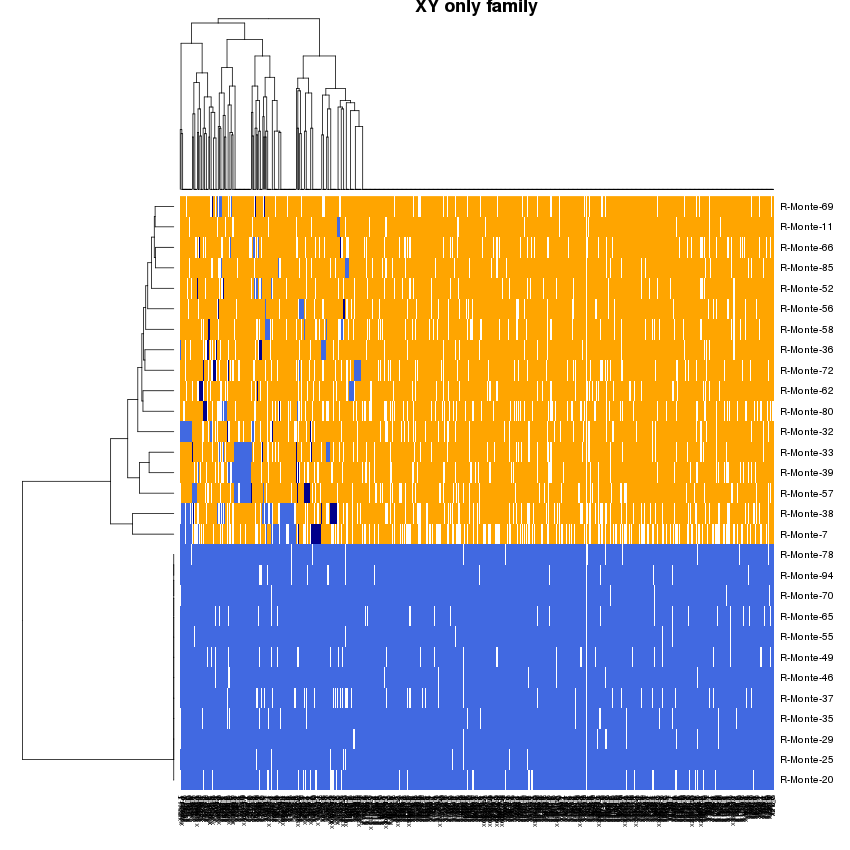

In [72]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/Fam_2_XY_linked_snps_het_only_heatmap.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "XY only family")



## ZW

In [34]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/Fam_2_ZWs_linked_snps_het_only.vcf > $wd/Fam_2_ZW_linked_snps_het_only_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/Fam_2_ZW_linked_snps_het_only_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/Fam_2_ZW_linked_snps_het_only_altered_adegenet 

PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_ZW_linked_snps_het_only_altered_adegenet.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_ZW_linked_snps_het_only_altered_adegenet
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_ZW_linked_snps_het_only_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_ZW_linked_snps_het_only_altered_adegenet-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_ZW_linked_snps_het_only_altered_adegenet-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//Fam_2_ZW_linked_snps_het_only_altered_adegenet-temporary.fam
wr

In [35]:
%%bash
wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/
sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/Fam_2_ZW_linked_snps_het_only_altered_adegenet.raw  $wd/Fam_2_ZW_linked_snps_het_only_heatmap


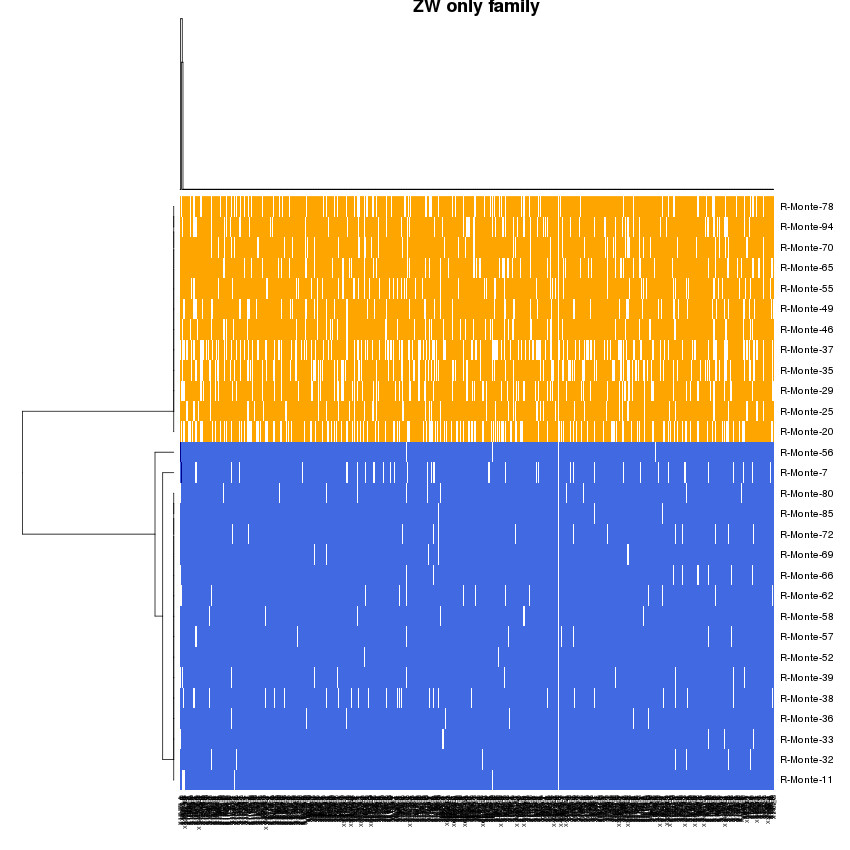

In [36]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/Fam_2_ZW_linked_snps_het_only_heatmap.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "ZW only family")



In [74]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/"
prefix = "Lmont_fam1"

### Tags to Pless

print "\n##  Mapping tags to R. temporaria  ##\n"

tags ="%s/%s" % (wd, "Putative_ZWlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to R. temporaria  ##

Number of multi-alingments kept: 24
Number of unique alingments kept: 45
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
69 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//blast_8000_chunks.fa

##  Mapping Rtemp chunks Nanorana  ##

Number of multi-alingments kept: 31
Number of unique alingments kept: 2
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
29 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//blast_8000_chunks.fa

##  Mapping Nanorana chunks Xenopus  ##

Number of multi-alingments kept: 4
Number of unique alingments kept: 3
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 
7 sequen

And now the ZWs

In [75]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2/"
prefix = "Lmont_fam1"

### Tags to Pless

print "\n##  Mapping tags to R. temporaria  ##\n"

tags ="%s/%s" % (wd, "Putative_XYlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to R. temporaria  ##

Number of multi-alingments kept: 8
Number of unique alingments kept: 36
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
44 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//blast_8000_chunks.fa

##  Mapping Rtemp chunks Nanorana  ##

Number of multi-alingments kept: 28
Number of unique alingments kept: 2
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
27 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2//blast_8000_chunks.fa

##  Mapping Nanorana chunks Xenopus  ##

Number of multi-alingments kept: 5
Number of unique alingments kept: 4
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 
9 sequenc

## REALLY NOT CONCLUSIVE - TRY AGAIN LATER!!

Try the alternative grouping for males and females - that is, try clustering samples into families based on their similarity on PC1 not PC2. grep

## Trying alt family configuration (FAM1_alt = left side of PCA)

In [55]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Lmontezumae_2/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/Sex_ID_info_Fam1_alt.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 1 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 10 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 19871
Number of samples = 31
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 19870
Number of putative X linked snps = 804
Number of putative X linked tags = 804
Number of putative Z linked markers = 1142
Number of putative Z linked tags = 1142


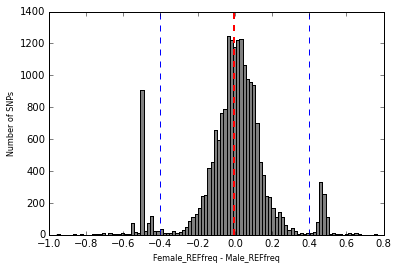


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 19871
Number of samples = 31
Number of loci with too few samples = 6803
Number of loci with low MAF = 0
Number of loci with enough data = 13053
Number of putative X linked snps = 184
Number of putative X linked tags = 184
Number of putative Z linked markers = 672
Number of putative Z linked tags = 672

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of females: 12
Number of males: 19
Number of Putative Y linked tags: 642
Number of Putative W linked tags: 912

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Lmontezumae_2

 ## After merging tags accross methods ## 

Final number of XY tags = 1446
Final number of ZW tags = 2055


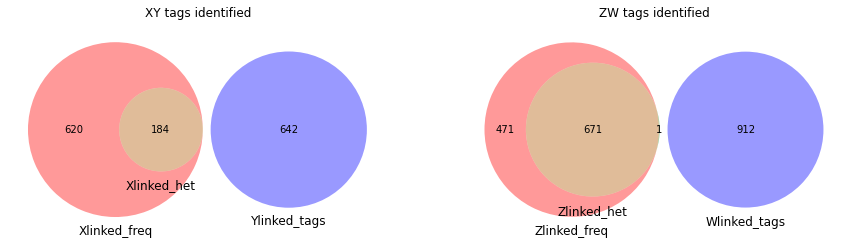

In [56]:
1XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

In [20]:
vcf_path = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/batch_1.vcf"

MISC.filter_vcf(vcf_path, XYset , "Fam_1_alt_XYs_linked_snps_het_only.vcf")
MISC.filter_vcf(vcf_path, ZWset , "Fam_1_alt_ZWs_linked_snps_het_only.vcf")

In [21]:

%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/Fam_1_alt_XYs_linked_snps_het_only.vcf > $wd/Fam_1_alt_XYs_linked_snps_het_only_adeg.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/Fam_1_alt_XYs_linked_snps_het_only_adeg.vcf --recode A --allow-extra-chr -out $wd/Fam_1_alt_XYs_linked_snps_het_only_adeg 


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_XYs_linked_snps_het_only_adeg.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_XYs_linked_snps_het_only_adeg
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_XYs_linked_snps_het_only_adeg.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_XYs_linked_snps_het_only_adeg-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_XYs_linked_snps_het_only_adeg-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_XYs_linked_snps_het_only_adeg-temporary.fam
written.
184 variant

In [23]:

%%bash
wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/
sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/Fam_1_alt_XYs_linked_snps_het_only_adeg.raw  $wd/Fam_1_alt_XYs_linked_snps_het_only_heatmap



In [6]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/Fam_1_alt_XYs_linked_snps_het_only_heatmap.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

svg(filename="/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/Fam_1_alt_XYs_linked_snps_het_only_heatmap.svg")
HM <- heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "XY only family")

dev.off()

#svg(HM,"/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/Fam_1_alt_XYs_linked_snps_het_only_heatmap" )


png 
  2 


## ZW tags


In [27]:

%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/Fam_1_alt_ZWs_linked_snps_het_only.vcf > $wd/Fam_1_alt_ZWs_linked_snps_het_only_adeg.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/Fam_1_alt_ZWs_linked_snps_het_only_adeg.vcf --recode A --allow-extra-chr -out $wd/Fam_1_alt_ZWs_linked_snps_het_only_adeg 


PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_ZWs_linked_snps_het_only_adeg.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_ZWs_linked_snps_het_only_adeg
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_ZWs_linked_snps_het_only_adeg.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_ZWs_linked_snps_het_only_adeg-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_ZWs_linked_snps_het_only_adeg-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt//Fam_1_alt_ZWs_linked_snps_het_only_adeg-temporary.fam
written.
672 variant

In [28]:

%%bash
wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/
sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/Fam_1_alt_ZWs_linked_snps_het_only_adeg.raw  $wd/Fam_1_alt_ZWs_linked_snps_het_only_heatmap



In [7]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/Fam_1_alt_ZWs_linked_snps_het_only_heatmap.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)



svg(filename="/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/Fam_1_alt_ZWs_linked_snps_het_only_heatmap.svg")
HM <- heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "'ZW' only family")


dev.off()




png 
  2 


In [92]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt"
prefix = "Lmont_fam1_alt"

### Tags to Pless

print "\n##  Mapping tags to R. temporaria  ##\n"

tags ="%s/%s" % (wd, "Putative_XYlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to R. temporaria  ##

Number of multi-alingments kept: 24
Number of unique alingments kept: 21
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
45 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/blast_8000_chunks.fa

##  Mapping Rtemp chunks Nanorana  ##

Number of multi-alingments kept: 26
Number of unique alingments kept: 1
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
22 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/blast_8000_chunks.fa

##  Mapping Nanorana chunks Xenopus  ##

Number of multi-alingments kept: 4
Number of unique alingments kept: 1
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 
5 

In [93]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt"
prefix = "Lmont_fam1_alt"

### Tags to Pless

print "\n##  Mapping tags to R. temporaria  ##\n"

tags ="%s/%s" % (wd, "Putative_ZWlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to R. temporaria  ##

Number of multi-alingments kept: 26
Number of unique alingments kept: 56
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
82 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/blast_8000_chunks.fa

##  Mapping Rtemp chunks Nanorana  ##

Number of multi-alingments kept: 53
Number of unique alingments kept: 4
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
45 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/blast_8000_chunks.fa

##  Mapping Nanorana chunks Xenopus  ##

Number of multi-alingments kept: 7
Number of unique alingments kept: 5
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 
12

In [ ]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam1_alt/"
prefix = "Lmont_fam2_alt"

### Tags to Pless

print "\n##  Mapping tags to R. temporaria  ##\n"

tags ="%s/%s" % (wd, "Putative_ZWlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]

## Family 2 alt

In [53]:
Parameter_dict = {}

##### Data ########################

Parameter_dict['Catalog'] =  "/home/djeffrie/Data/RADseq/Lmontezumae_2/batch_1.catalog.tags.tsv.gz" ## Path to the catalog file - used by all approaches.
Parameter_dict['VCF'] =  "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1.vcf" ## path to vcf file (note this will be altered to make header compatible with Pyvcf. New vcf will have same name with ".altered" appended to the end). Used by Approach i) and ii)
Parameter_dict['Pop_map'] = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/Sex_ID_info_Fam2_alt.txt" ## path to population map file containing sex information. Same format as Stacks pop map file. Used by all approaches.

###### threshold parameters #######

# 1. Frequency approach
Parameter_dict['X_or_Z_freq_threshold'] = 0.4  ## (Default = 0.4) The lower threshold for the freq caluclation to find sex linked snps, e.g. for an XY system, a threshold of 0.4 means that f(F) - f(M) can be >= 0.4 and <= 0.6 (the upper threshold is automatically calculated to be the same distance above 0.5 as the lower threshold is below 0.5) 
Parameter_dict['sample_presence_cutoff1'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold1'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci below this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold1'] =  0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 
Parameter_dict['homogametic_REF_allele_freq'] = 1 ## (Default = 0.95) The sex linked SNP will be the minor allele, so a check is done to make sure that the homogametic sex is above the threshold specified for the major allele. In theory this should be 1. But allowing for some error 0.95 is used as a default. 

# 2. Heterozygosity approach
Parameter_dict['homogamtic_homozygosity_threshold'] = 1 ## (Default = 0.9) The minimum number of the homogametic sex which must not have the tag for that tag to be considered linked to the sex-limited chromosome
Parameter_dict['heterogamtic_heterozygosity_threshold'] = 1 ## (Default = 0.5) The lower threshold for the proportion of heterozygotes in the heterogametic sex at a locus 
Parameter_dict['sample_presence_cutoff2'] = 0.75 ## (Default = 0.75) a locus must be called in at least this proportion of all samples (not within populations) to be considered
Parameter_dict['coverage_threshold2'] = 3 ## (Default = 3) a locus must have at least this threshold in a sample to be considered for that sample. Note that loci bels this threshold will be removed from a sample, and this can push the locus below the sample presence cut-off, which will then remove the locus.
Parameter_dict['maf_threshold2'] = 0.05 ## (Default = 0.05) minor allele frequency cutoff for a locus across all samples. 

# 3. Sex specific presence or absence approach
Parameter_dict['sex_presence_threshold'] =  0.5 ## (Default = 0.5) The minimum percenatage of the heterogametic sex that a tag must be present in.



##### Using SNP frequency approach #### 

Number of loci = 24076
Number of samples = 37
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 24075
Number of putative X linked snps = 1119
Number of putative X linked tags = 1119
Number of putative Z linked markers = 822
Number of putative Z linked tags = 822


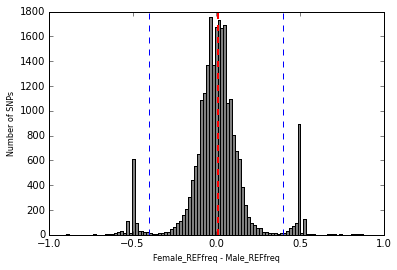


***DONE!***


##### Using SNP heterozygosity approach #####
 
Number of loci = 24076
Number of samples = 37
Number of loci with too few samples = 0
Number of loci with low MAF = 0
Number of loci with enough data = 24075
Number of putative X linked snps = 862
Number of putative X linked tags = 862
Number of putative Z linked markers = 577
Number of putative Z linked tags = 577

 ### DONE! ### 


##### Using Sex specific tag approach ##### 


SUMMARY:
Number of females: 20
Number of males: 17
Number of Putative Y linked tags: 983
Number of Putative W linked tags: 628

 ### DONE! ###

Sex linked tags outputted to fastas 'Putative_XYlinked_makers.fa' and Putative_ZWlinked_makers.fa
in the directory /home/djeffrie/Data/RADseq/Lmontezumae_2

 ## After merging tags accross methods ## 

Final number of XY tags = 2102
Final number of ZW tags = 1450


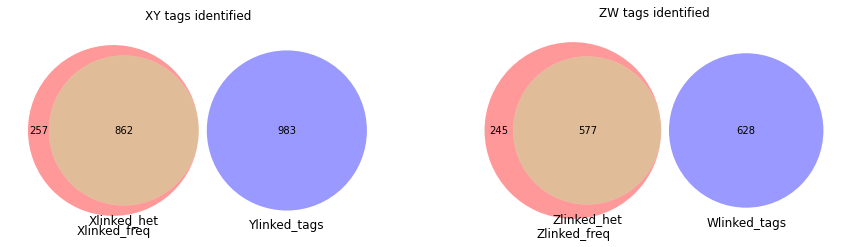

In [54]:
XYset, ZWset = MISC.Super_SLM_finder(Parameter_dict, "111")

In [84]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_plink 




PLINK v1.90b3.39 64-bit (4 Aug 2016)       https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1_plink.log.
Options in effect:
  --allow-extra-chr
  --out /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1_plink
  --recode A
  --vcf /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1_altered_adegenet.vcf

32083 MB RAM detected; reserving 16041 MB for main workspace.
--vcf:
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1_plink-temporary.bed
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1_plink-temporary.bim
+
/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1_plink-temporary.fam
written.
24076 variants loaded from .bim file.
37 people (0 males, 0 females, 37 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/home/djeffrie/Data/RADseq/Lmont

In [86]:
%%bash
wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/
sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_plink.raw  $wd/batch_1_heatmap


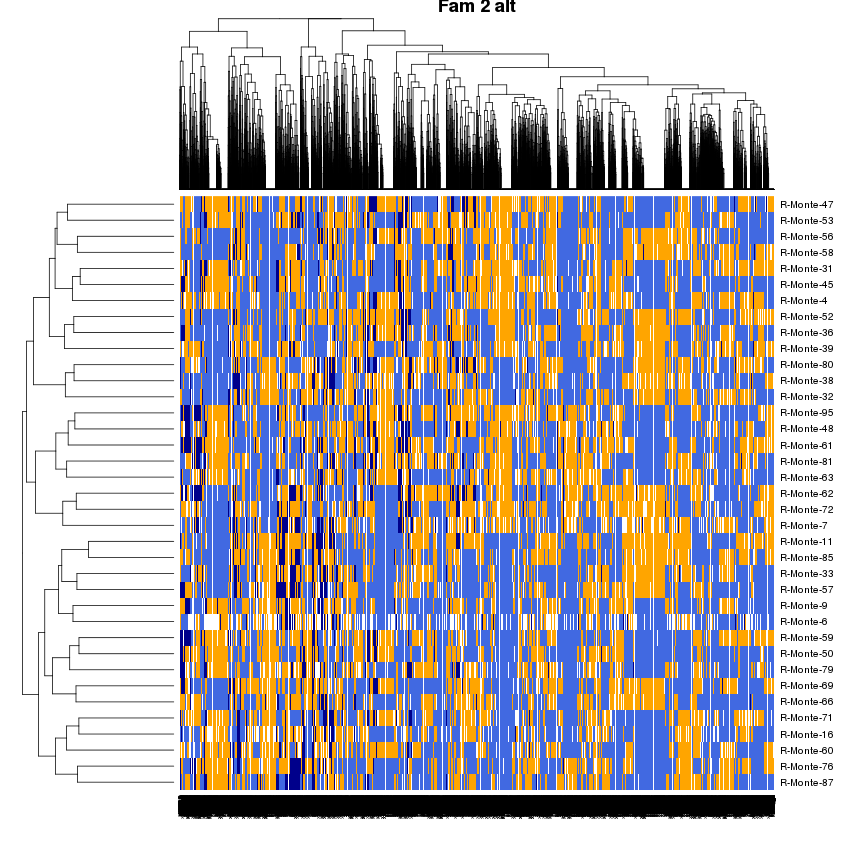

In [87]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1_heatmap.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "Fam 2 alt")


In [ ]:
vcf_path = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1.vcf"

MISC.filter_vcf(vcf_path, XYset , "Fam_1_alt_XYs_linked_snps_het_only.vcf")
MISC.filter_vcf(vcf_path, ZWset , "Fam_1_alt_ZWs_linked_snps_het_only.vcf")

In [ ]:
%%bash

wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt  ## just change this line

## XY only data 
sed 's/_/-/g' $wd/batch_1.vcf > $wd/batch_1_altered_adegenet.vcf

~/Programs/plink_linux_x86_64/plink --vcf $wd/batch_1_altered_adegenet.vcf --recode A --allow-extra-chr -out $wd/batch_1_plink 



In [ ]:
%%bash
wd=/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/
sh /home/djeffrie/Dropbox/My_Dropbox_Scripts/Bash/Make_heatmap_input.sh  $wd/batch_1_plink.raw  $wd/batch_1_heatmap


In [ ]:
%%R -w 30 -h 30 -u cm

XY_heatmap_data <- read.delim("/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/batch_1_heatmap.raw", row.names = 1)
XY_heatmap_data_sorted <- XY_heatmap_data[order(row.names(XY_heatmap_data), decreasing = T), ]
XY_heatmap_data_datmat <- as.matrix(XY_heatmap_data_sorted)

heatmap(XY_heatmap_data_datmat, scale='none', col = c("royalblue", "orange", "darkblue"), cexRow = 1, main = "Fam 2 alt")


In [88]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/"
prefix = "Lmont_fam2_alt"

### Tags to Pless

print "\n##  Mapping tags to R. temporaria  ##\n"

tags ="%s/%s" % (wd, "Putative_XYlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to R. temporaria  ##

Number of multi-alingments kept: 31
Number of unique alingments kept: 60
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
91 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt//blast_8000_chunks.fa

##  Mapping Rtemp chunks Nanorana  ##

Number of multi-alingments kept: 54
Number of unique alingments kept: 4
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
48 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt//blast_8000_chunks.fa

##  Mapping Nanorana chunks Xenopus  ##

Number of multi-alingments kept: 10
Number of unique alingments kept: 4
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 

In [94]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil

Rtemp_fasta = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa"
Rtemp_db = "/home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2-blastn-db"

Nano_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta"
Nanorana_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_blast_db"

Xen_db = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xenoupus_blastdb"
Xen_fasta = "/home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa"


best_hit_crit = 1e-5
Eval_threshold = 1e-20
Window = 8000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/"
prefix = "Lmont_fam2_alt"

### Tags to Pless

print "\n##  Mapping tags to R. temporaria  ##\n"

tags ="%s/%s" % (wd, "Putative_ZWlinked_makers.fa")
tags_to_Rtemp_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rtemp_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=Rtemp_db, outfmt=5, out=tags_to_Rtemp_blastnouts)
stdout, stderr = blastn_cline()

Rtemp_records = MISC.BlastParseExtra(tags_to_Rtemp_blastnouts, Rtemp_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rtemp_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_blast_chunks)


### Rtemp chunks to Nanorana

print "\n##  Mapping Rtemp chunks Nanorana  ##\n"

tags_Rtemp_Nano_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_blast_chunks, db=Nanorana_db, outfmt=5, out=tags_Rtemp_Nano_blastnouts)
stdout, stderr = blastn_cline()

Nano_records = MISC.BlastParseExtra(tags_Rtemp_Nano_blastnouts, Nano_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_Nano_blast_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_8k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Rtemp_Nano_blast_chunks)



### Nanorana chunks to Xenopus

print "\n##  Mapping Nanorana chunks Xenopus  ##\n"

tags_Rtemp_Nano_Xen_blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "Rtemp_Nano_Xen_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=Rtemp_Nano_blast_chunks, db=Xen_db, outfmt=5, out=tags_Rtemp_Nano_Xen_blastnouts)
stdout, stderr = blastn_cline()

Xen_records = MISC.BlastParseExtra(tags_Rtemp_Nano_Xen_blastnouts, Xen_fasta , best_hit_crit, Eval_threshold,Window)

Xen_chunks = "%s/%s" % (wd,"%s_%s" % (prefix, "Rtemp_Nano_Xen_8kb_chunks.fa"))
                                      
shutil.move("%s/%s" % (wd,"blast_8000_chunks.fa"), Xen_chunks)



### Get the Xenopus summary

print "\n##  Final Xenopus hits  ##\n"

from collections import Counter 
Xen_hits = []
for i in Xen_records:
    Xen_hits.append(Xen_records[i]["Ref_hit_id"])
    print i, Xen_records[i]["Ref_hit_id"]


##  Mapping tags to R. temporaria  ##

Number of multi-alingments kept: 15
Number of unique alingments kept: 28
Getting subject scaffold segments from /home/djeffrie/Data/Genomes/Rtemp/V2/Rtemp_gapfilled_iter2_flted2.fa . . . 
43 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt//blast_8000_chunks.fa

##  Mapping Rtemp chunks Nanorana  ##

Number of multi-alingments kept: 25
Number of unique alingments kept: 1
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Nanorana_blast_db/Nanorana_parkeri.genome.v2.fasta . . . 
24 sequence scaffold segments are in /home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt//blast_8000_chunks.fa

##  Mapping Nanorana chunks Xenopus  ##

Number of multi-alingments kept: 5
Number of unique alingments kept: 2
Getting subject scaffold segments from /home/djeffrie/Data/RADseq/STOECK/Bviridis/Genome_mapping/Xenopus_genome/Xtropicalis.v9.repeatMasked.fa . . . 


So in total, from the two families:

Fam 1.

"XY"

scaffold88 Chr01  
scaffold1770 Chr02    
scaffold183 Chr01  
scaffold2798 Chr01  
scaffold54 Chr01  

"ZW"
scaffold162 Chr01  
scaffold501 Chr01  
scaffold357 Chr06  
scaffold36 Chr01  
scaffold1311 Chr01  
scaffold1550 Chr01  
scaffold693 Chr04  
scaffold1051 scaffold_90  
scaffold458 Chr09  
scaffold899 Chr01  
scaffold137 Chr06  
scaffold1770 Chr02  

Fam 2. 

"XY"
scaffold162 Chr01  
scaffold501 Chr01  
scaffold357 Chr06  
scaffold36 Chr01  
scaffold1311 Chr01  
scaffold54 Chr01  
scaffold144 Chr08  
scaffold2988 Chr06  
scaffold693 Chr04  
scaffold18 Chr01  
scaffold899 Chr01  
scaffold2798 Chr01  
scaffold137 Chr06  
scaffold1770 Chr02  


"ZW"
scaffold88 Chr01  
scaffold183 Chr01  
scaffold311 Chr06  
scaffold1550 Chr01  
scaffold282 Chr04  
scaffold9 Chr04  
scaffold334 Chr01  


38 hits on Xenopus, of which 22 (57%) hit Chr 01.


###Also . . . 

The hits are very conserved among families. I.e. what is identified as XY or ZW in one family, was also identied as XY or ZW in the other family. If I had mixed up sex and families, I would not expect this of autosomal loci that happen to be heterozygous in one population and not the other. 



So I think the real assignments on the original PCA to family one and two and males and females are as follows:




                            ||    
             Females (fam1) ||   Females (fam2)
                            ||
                            ||
           _________________||__________________
                            ||
                            ||
                            ||
            Males (fam1)    ||   Males (fam2) 
                            ||
                            ||



In [51]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil


myGenome_fasta = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs.fasta"
myGenome_db = "/home/djeffrie/Data/RADseq/R_temp_fams/Genome_mapping/Final_map_files/Final_ordered_Rtemp_scaffolds/Rtemp_Linkage_map_ordered_scaffolds_XenIDs_blastn_db"

best_hit_crit = 1e-5
Eval_threshold = 1e-30
Window = 2000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/"
prefix = "L_mont_all"

### Tags to Rtemp

print "\n##  Mapping tags to L pip transcriptome  ##\n"

tags ="%s/%s" % (wd, "All_sex_linked_markers_fams1_2.fa")
blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rclam_trans_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=myGenome_db, outfmt=5, out=blastnouts)
stdout, stderr = blastn_cline()

records = MISC.BlastParseExtra(blastnouts, myGenome_fasta , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rpip_trans_2k_chunks.fa"))

#shutil.move("%s/%s" % (wd,"blast_2000_chunks.fa"), Rtemp_blast_chunks)




##  Mapping tags to L pip transcriptome  ##

Number of multi-alingments kept: 7
Number of unique alingments kept: 18


In [52]:
from collections import Counter

IDs = []
for i in records:
    IDs.append(records[i]["Ref_hit_id"].split("_")[1])
    
Counter(IDs)

Counter({'Chr01': 20, 'Chr05': 2, 'Chr07': 2, 'Chr02': 1})

In [1]:
from Bio.Blast.Applications import NcbiblastnCommandline
import MISC_RAD_tools as MISC
import shutil


L_pip = "/home/djeffrie/Data/Genomes/Rana_pipiens_transcriptome_Christenson_2014/Rpipiens_full_transcriptome_v001.fasta"
L_pip_db = "/home/djeffrie/Data/Genomes/Rana_pipiens_transcriptome_Christenson_2014/R_pip_trans_blastn"

best_hit_crit = 1e-5
Eval_threshold = 1e-10
Window = 2000

wd = "/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt/"
prefix = "L_mont"

### Tags to Rtemp

print "\n##  Mapping tags to L pip transcriptome  ##\n"

tags ="%s/%s" % (wd, "Putative_XYlinked_makers.fa")
blastnouts = "%s/%s" % (wd, "%s_%s" % (prefix, "tags_Rclam_trans_blastnouts.xml"))

blastn_cline = NcbiblastnCommandline(query=tags, db=L_pip_db, outfmt=5, out=blastnouts)
stdout, stderr = blastn_cline()

records = MISC.BlastParseExtra(blastnouts, L_pip , best_hit_crit, Eval_threshold,Window)

Rtemp_blast_chunks = "%s/%s" % (wd,  "%s_%s" % (prefix, "Rpip_trans_2k_chunks.fa"))

shutil.move("%s/%s" % (wd,"blast_2000_chunks.fa"), Rtemp_blast_chunks)




##  Mapping tags to L pip transcriptome  ##

Number of multi-alingments kept: 14
Number of unique alingments kept: 32


IOError: [Errno 2] No such file or directory: '/home/djeffrie/Data/RADseq/Lmontezumae_2/Populations_Fam2_alt//blast_2000_chunks.fa'

In [2]:
records

{u'X_linkedLocusID_100949_9388211_Xlinked_het': {'Evalue': 7.03657e-36,
  'Hit_end_coord': 245,
  'Hit_start_coord': 332,
  'Ref_hit_id': 'Rana_pipiens_Transcript_541970'},
 u'X_linkedLocusID_100949_9388254_Xlinked_het': {'Evalue': 7.03657e-36,
  'Hit_end_coord': 245,
  'Hit_start_coord': 332,
  'Ref_hit_id': 'Rana_pipiens_Transcript_541970'},
 u'X_linkedLocusID_15558_1446876_Xlinked_het': {'Evalue': 2.01258e-16,
  'Hit_end_coord': 83,
  'Hit_start_coord': 1,
  'Ref_hit_id': 'Rana_pipiens_Transcript_546193'},
 u'X_linkedLocusID_18074_1680854_Xlinked_het': {'Evalue': 5.51711e-27,
  'Hit_end_coord': 217,
  'Hit_start_coord': 125,
  'Ref_hit_id': 'Rana_pipiens_Transcript_449987'},
 u'X_linkedLocusID_21097_1961987_Xlinked_het': {'Evalue': 5.4396e-37,
  'Hit_end_coord': 213,
  'Hit_start_coord': 121,
  'Ref_hit_id': 'Rana_pipiens_Transcript_384164'},
 u'X_linkedLocusID_21669_2015162_Xlinked_het': {'Evalue': 5.47822e-32,
  'Hit_end_coord': 301,
  'Hit_start_coord': 209,
  'Ref_hit_id': 'Rana